In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"


# Field Descriptions 

Transaction Fields
- transaction_id: Unique identifier for each transaction.
timestamp: Date and time of the transaction. This is crucial for time-series analysis and identifying unusual transaction patterns over time.
- sender_account_id: Account number of the sender.
- receiver_account_id: Account number of the receiver.
- transaction_type: E.g., 'Deposit', 'Withdrawal', 'Transfer', 'Online Purchase', 'Bill Payment'. Diverse transaction types add realism.
- amount: The value of the transaction. This is key for identifying large or unusual amounts.
- currency: E.g., 'USD', 'EUR', 'GBP', 'INR'. Multiple currencies add complexity and realism.
- sender_bank: Bank of the sender (internal or external).
- receiver_bank: Bank of the receiver (internal or external).
- location: Geographic location of the transaction (e.g., city, country). This can help identify transactions from high-risk jurisdictions or unusual international transfers.
- transaction_purpose: (Optional but good for realism) A brief description or category of the transaction's purpose.
- is_suspicious: A boolean flag (True/False) that I'll manually set for a small percentage of transactions to represent potential AML red flags. This allows you to test your detection algorithms.




# Noise in the data 

Missing Values (NaNs):
- amount: Sometimes missing.
- transaction_type: Sometimes missing.
- location: Sometimes missing.
- transaction_purpose: More frequently missing.

Inconsistent Formatting:
- currency: Mixed casing ('usd', 'USD', 'Usd').
- transaction_type: Variations ('Transfer ', 'transfer', 'Depsoit').
- location: Typos ('New YorK', 'Londonn').
- timestamp: Some entries might be incorrect date formats (though pandas usually handles this well on load, it's good to be aware of the type of mess).


Outliers/Typographical Errors in Numeric Data:
- amount: A few extremely large or negative (incorrect) values.

Duplicates:
- Some transactions will be exact duplicates.

Inaccurate Data (Minor):
- Slight discrepancies in banks or locations that don't match the primary sender/receiver.
- Timestamps slightly out of order (though sorting later resolves this, initial generation can be messy).


Dummy Accounts/Generic Descriptions:
- Some accounts might look like placeholders (TEST_ACC, SUSP_ACC).
- Generic or empty transaction purposes.



Below are some steps to handle NULLs in the dataset.

```
# Convert timestamps and dates to datetime objects
df_transactions['timestamp'] = pd.to_datetime(df_transactions['timestamp'])
df_customers['date_of_birth'] = pd.to_datetime(df_customers['date_of_birth'])
df_customers['customer_since'] = pd.to_datetime(df_customers['customer_since'])

# Clean and standardize 'amount' - handle NaNs and negative values
df_transactions['amount'] = pd.to_numeric(df_transactions['amount'], errors='coerce')
df_transactions['amount'].fillna(0, inplace=True) # Fill NaNs with 0 for calculations
df_transactions['amount'] = df_transactions['amount'].abs() # Use absolute value for amount, or flag negatives as suspicious

# Clean and standardize 'transaction_type'
df_transactions['transaction_type'] = df_transactions['transaction_type'].str.strip().str.capitalize()
df_transactions['transaction_type'].fillna('Unknown', inplace=True)
valid_transaction_types = ['Deposit', 'Withdrawal', 'Transfer', 'Online purchase', 'Bill payment', 'Loan repayment']
df_transactions.loc[~df_transactions['transaction_type'].isin(valid_transaction_types), 'transaction_type'] = 'Other'

# Clean and standardize 'currency'
df_transactions['currency'] = df_transactions['currency'].str.upper().str.strip()
df_transactions['currency'].fillna('UNKNOWN', inplace=True)

# Clean and standardize 'location'
df_transactions['location'] = df_transactions['location'].str.strip().str.title() # Title case for consistency
df_transactions['location'].fillna('Unknown', inplace=True)
HIGH_RISK_LOCATIONS = ['Panama City', 'Cayman Islands', 'Dubai', 'Singapore', 'Zurich'] # Adjusted based on previous generation

# Clean customer data
df_customers['occupation'] = df_customers['occupation'].str.strip().str.title()
df_customers['occupation'].fillna('Unknown', inplace=True)
df_customers['annual_income_usd'] = pd.to_numeric(df_customers['annual_income_usd'], errors='coerce').fillna(0)
df_customers['credit_score'] = pd.to_numeric(df_customers['credit_score'], errors='coerce').fillna(0) # Fill with 0 or a median/mean


```



To keep the scope simple, we exluclued noise while generated test data for this exercise. 


### Load the synthetic_banking_transactions.csv file to a dataframe.

In [3]:
df = pd.read_csv("synthetic_banking_transactions.csv")
df

transaction_id                   timestamp sender_account_id  \
0         TXN0002457  2023-01-01 01:30:33.350280     ACC1499124175   
1         TXN0011184  2023-01-01 01:58:08.773998     ACC7416059279   
2         TXN0003728  2023-01-01 02:15:07.201258     ACC4160476591   
3         TXN0011215  2023-01-01 03:14:20.956603     ACC7829107700   
4         TXN0002454  2023-01-01 03:21:08.832910     ACC1273642132   
...              ...                         ...               ...   
15513   TXN_S0001498  2023-12-30 22:29:21.514150     ACC6822622233   
15514   TXN_S0012792  2023-12-30 22:30:28.559025     ACC9840333060   
15515     TXN0001108  2023-12-30 22:31:08.699832     ACC6816347498   
15516     TXN0000203  2023-12-30 22:46:13.756359     ACC1461645679   
15517     TXN0010631  2023-12-30 23:03:16.835771     ACC6221555908   

      receiver_account_id transaction_type    amount currency  \
0           ACC4315862424       Withdrawal  37024.07      USD   
1           ACC9917457682          Deposit   6737.57      GBP   
2           ACC5192649511          Deposit  29729.13      EUR   
3           ACC1975423441     Bill Payment  30017.30      EUR   
4           ACC4601459057          Deposit   8322.98      GBP   
...                   ...              ...       ...      ...   
15513       ACC6116709510          Deposit   9129.86      USD   
15514       ACC5315572453          Deposit   9179.38      USD   
15515       ACC6527084307  Online Purchase  22207.63      AUD   
15516       ACC2586160833       Withdrawal  13527.96      CAD   
15517       ACC9966716612   Loan Repayment  46476.10      EUR   

           sender_bank    receiver_bank     location  \
0               Bank B           Bank C     New York   
1      Global Bank Co.           Bank C       Mumbai   
2               Bank C           Bank C        Delhi   
3               Bank A  Global Bank Co.  Los Angeles   
4       Universal Fin.           Bank C       Mumbai   
...                ...              ...          ...   
15513           Bank B           Bank A       Mumbai   
15514           Bank C           Bank A    Bengaluru   
15515  Global Bank Co.   Universal Fin.       Sydney   
15516   Universal Fin.           Bank A        Delhi   
15517           Bank B           Bank C      Chicago   

                transaction_purpose  is_suspicious  
0                Payment for salary          False  
1      Payment for medical expenses          False  
2              Payment for services          False  
3            Payment for investment          False  
4       Payment for consulting fees          False  
...                             ...            ...  
15513                  Cash Deposit           True  
15514                  Cash Deposit           True  
15515             Payment for goods          False  
15516              Payment for loan          False  
15517   Payment for consulting fees          False  

[15518 rows x 12 columns]

### Find the number of records, number of columns and column type. Also, check if there are any NULL values in any of the columns. 

NULL handling is an importance data preprocessing step.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15518 entries, 0 to 15517
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       15518 non-null  object 
 1   timestamp            15518 non-null  object 
 2   sender_account_id    15518 non-null  object 
 3   receiver_account_id  15518 non-null  object 
 4   transaction_type     15518 non-null  object 
 5   amount               15518 non-null  float64
 6   currency             15518 non-null  object 
 7   sender_bank          15518 non-null  object 
 8   receiver_bank        15518 non-null  object 
 9   location             15518 non-null  object 
 10  transaction_purpose  15518 non-null  object 
 11  is_suspicious        15518 non-null  bool   
dtypes: bool(1), float64(1), object(10)
memory usage: 1.3+ MB


Convert timestamp to Timestamp data type and set the index to the "timestamp" field. Timeseries dataframe provide functions like resample, rolling aggregate etc.

In [5]:
df["timestamp"] = pd.to_datetime(df['timestamp'])
df["timestamp"]

0       2023-01-01 01:30:33.350280
1       2023-01-01 01:58:08.773998
2       2023-01-01 02:15:07.201258
3       2023-01-01 03:14:20.956603
4       2023-01-01 03:21:08.832910
                   ...            
15513   2023-12-30 22:29:21.514150
15514   2023-12-30 22:30:28.559025
15515   2023-12-30 22:31:08.699832
15516   2023-12-30 22:46:13.756359
15517   2023-12-30 23:03:16.835771
Name: timestamp, Length: 15518, dtype: datetime64[ns]

In [6]:
df.set_index("timestamp", inplace=True)

# Exploratory Data Analysis

### Find the number of transactions by each day.

<Axes: xlabel='timestamp'>

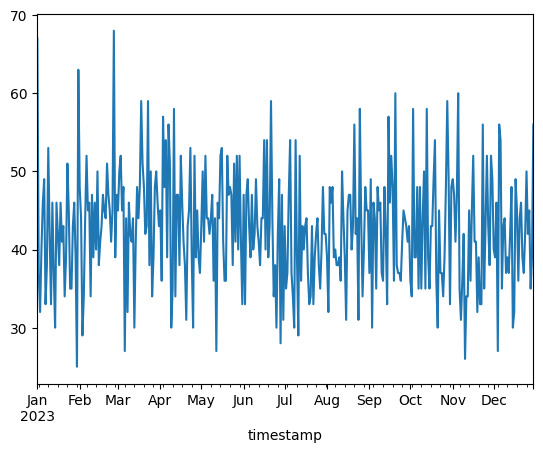

In [7]:
df["transaction_id"].resample("D").count().plot()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15518 entries, 2023-01-01 01:30:33.350280 to 2023-12-30 23:03:16.835771
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       15518 non-null  object 
 1   sender_account_id    15518 non-null  object 
 2   receiver_account_id  15518 non-null  object 
 3   transaction_type     15518 non-null  object 
 4   amount               15518 non-null  float64
 5   currency             15518 non-null  object 
 6   sender_bank          15518 non-null  object 
 7   receiver_bank        15518 non-null  object 
 8   location             15518 non-null  object 
 9   transaction_purpose  15518 non-null  object 
 10  is_suspicious        15518 non-null  bool   
dtypes: bool(1), float64(1), object(9)
memory usage: 1.3+ MB


### Find the frequency of each transaction_type and display them using a bar plot.Which are the most common transaction type?

<Axes: ylabel='transaction_type'>

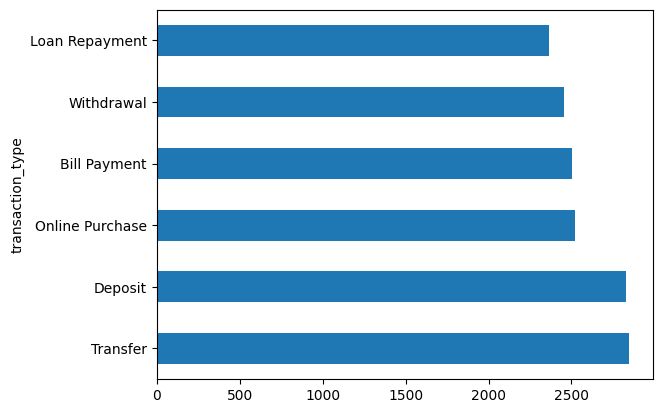

In [9]:
a = df.transaction_type.value_counts()
a.plot.barh()

### Find the frequency of currencies and display them using a bar plot. Which are the most common currency?

<Axes: ylabel='currency'>

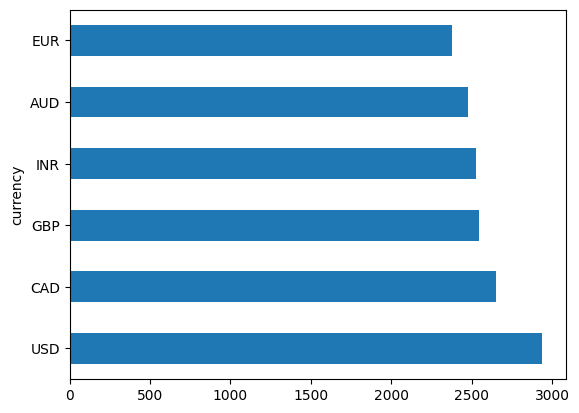

In [10]:
a = df.currency.value_counts()
a.plot.barh()

### Normalize currency to USD using the following current conversation rates. 


In practice, you can get the currency conversion rate for a given time period using API calls. For simplicity, we are using the static currency conversion rates as of 2025-06-09.

```
currency_rate = {'EUR': 1.14,
'AUD': 0.65,
'INR': 0.012,
'GBP': 1.36,
'CAD': 0.73,
'USD': 1
}
```

In [11]:
currency_rate = {'EUR': 1.14,
'AUD': 0.65,
'INR': 0.012,
'GBP': 1.36,
'CAD': 0.73,
'USD': 1
}

df["amount_usd"] = df["amount"] * df["currency"].map(currency_rate)
df

transaction_id sender_account_id  \
timestamp                                                     
2023-01-01 01:30:33.350280     TXN0002457     ACC1499124175   
2023-01-01 01:58:08.773998     TXN0011184     ACC7416059279   
2023-01-01 02:15:07.201258     TXN0003728     ACC4160476591   
2023-01-01 03:14:20.956603     TXN0011215     ACC7829107700   
2023-01-01 03:21:08.832910     TXN0002454     ACC1273642132   
...                                   ...               ...   
2023-12-30 22:29:21.514150   TXN_S0001498     ACC6822622233   
2023-12-30 22:30:28.559025   TXN_S0012792     ACC9840333060   
2023-12-30 22:31:08.699832     TXN0001108     ACC6816347498   
2023-12-30 22:46:13.756359     TXN0000203     ACC1461645679   
2023-12-30 23:03:16.835771     TXN0010631     ACC6221555908   

                           receiver_account_id transaction_type    amount  \
timestamp                                                                   
2023-01-01 01:30:33.350280       ACC4315862424       Withdrawal  37024.07   
2023-01-01 01:58:08.773998       ACC9917457682          Deposit   6737.57   
2023-01-01 02:15:07.201258       ACC5192649511          Deposit  29729.13   
2023-01-01 03:14:20.956603       ACC1975423441     Bill Payment  30017.30   
2023-01-01 03:21:08.832910       ACC4601459057          Deposit   8322.98   
...                                        ...              ...       ...   
2023-12-30 22:29:21.514150       ACC6116709510          Deposit   9129.86   
2023-12-30 22:30:28.559025       ACC5315572453          Deposit   9179.38   
2023-12-30 22:31:08.699832       ACC6527084307  Online Purchase  22207.63   
2023-12-30 22:46:13.756359       ACC2586160833       Withdrawal  13527.96   
2023-12-30 23:03:16.835771       ACC9966716612   Loan Repayment  46476.10   

                           currency      sender_bank    receiver_bank  \
timestamp                                                               
2023-01-01 01:30:33.350280      USD           Bank B           Bank C   
2023-01-01 01:58:08.773998      GBP  Global Bank Co.           Bank C   
2023-01-01 02:15:07.201258      EUR           Bank C           Bank C   
2023-01-01 03:14:20.956603      EUR           Bank A  Global Bank Co.   
2023-01-01 03:21:08.832910      GBP   Universal Fin.           Bank C   
...                             ...              ...              ...   
2023-12-30 22:29:21.514150      USD           Bank B           Bank A   
2023-12-30 22:30:28.559025      USD           Bank C           Bank A   
2023-12-30 22:31:08.699832      AUD  Global Bank Co.   Universal Fin.   
2023-12-30 22:46:13.756359      CAD   Universal Fin.           Bank A   
2023-12-30 23:03:16.835771      EUR           Bank B           Bank C   

                               location           transaction_purpose  \
timestamp                                                               
2023-01-01 01:30:33.350280     New York            Payment for salary   
2023-01-01 01:58:08.773998       Mumbai  Payment for medical expenses   
2023-01-01 02:15:07.201258        Delhi          Payment for services   
2023-01-01 03:14:20.956603  Los Angeles        Payment for investment   
2023-01-01 03:21:08.832910       Mumbai   Payment for consulting fees   
...                                 ...                           ...   
2023-12-30 22:29:21.514150       Mumbai                  Cash Deposit   
2023-12-30 22:30:28.559025    Bengaluru                  Cash Deposit   
2023-12-30 22:31:08.699832       Sydney             Payment for goods   
2023-12-30 22:46:13.756359        Delhi              Payment for loan   
2023-12-30 23:03:16.835771      Chicago   Payment for consulting fees   

                            is_suspicious  amount_usd  
timestamp                                              
2023-01-01 01:30:33.350280          False  37024.0700  
2023-01-01 01:58:08.773998          False   9163.0952  
2023-01-01 02:15:07.201258          False  33891.2082  
2023-01-01 03:14:20.95660

Show the distribution of the amount_usd. What is range of this variable? Do you see any skewness in the values?

<Axes: xlabel='amount_usd', ylabel='Count'>

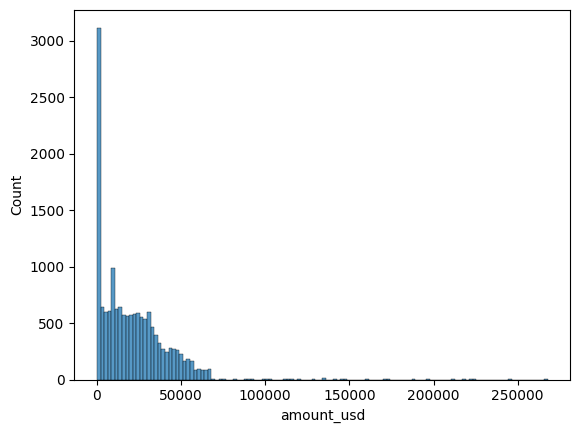

In [12]:
sns.histplot(df.amount_usd)

What are type of transactions common for transaction about above 75,000 USD.

In [13]:
df[df["amount_usd"]>75000]["transaction_type"].value_counts()

transaction_type
Transfer    47
Name: count, dtype: int64

Show the boxplot of amount_usd by various transaction_type. Do you see any outliers of the amount_usd for any transaction_type?

<Axes: xlabel='transaction_type', ylabel='amount_usd'>

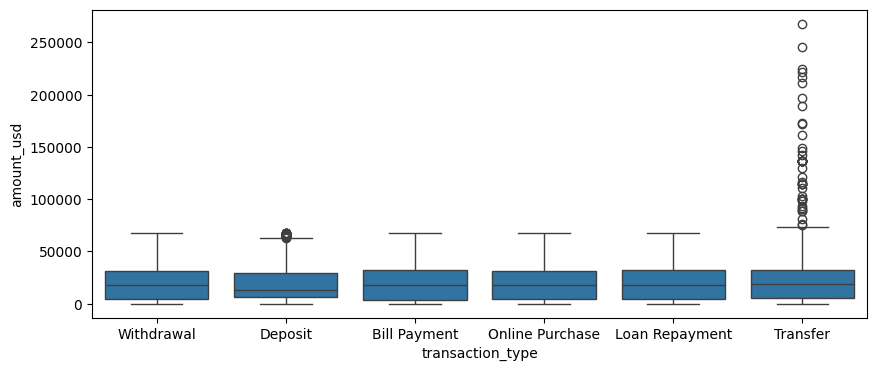

In [14]:
plt.subplots(figsize = (10, 4))
sns.boxplot(df, x = "transaction_type", y="amount_usd")

Show the boxplot of amount_usd by various currency. Do you see any outliers of the amount_usd for any currency?

<Axes: xlabel='currency', ylabel='amount_usd'>

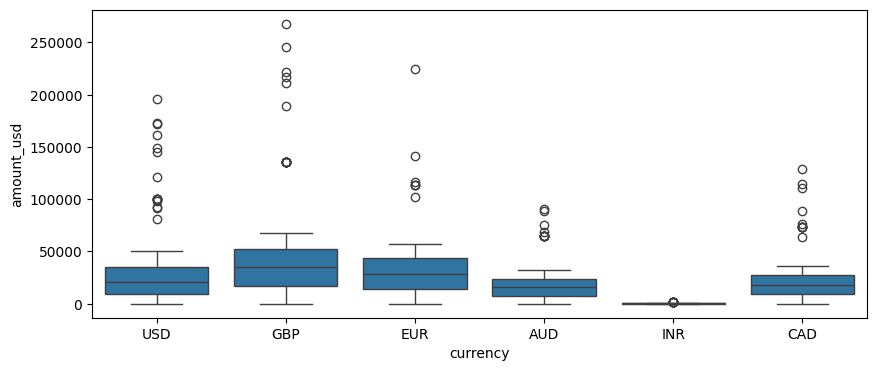

In [15]:
plt.subplots(figsize = (10, 4))
sns.boxplot(df, x = "currency", y="amount_usd")

Show the boxplot of amount_usd by the purpose values. Do you see any outliers of the amount_usd for each purposes?

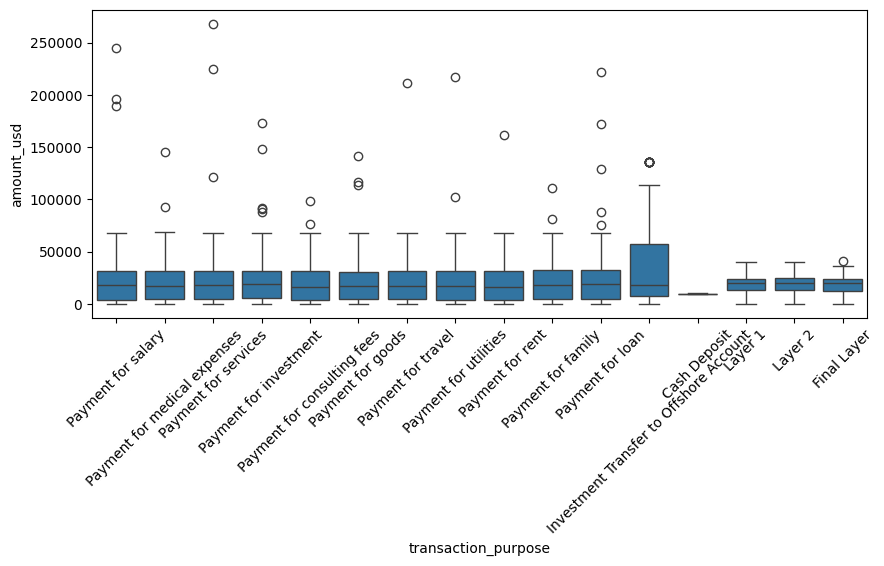

In [16]:
plt.subplots(figsize = (10, 4))
ax = sns.boxplot(df, x = "transaction_purpose", y="amount_usd")
ax.tick_params(axis='x', labelrotation=45)

What are the various locations of the transactions? Plot the location on a map. Use plotly for displaying geographic map. To show the location in the map, we need to determine the lattitude and longitude of each location. You can get lat-long coordinate from the city using API, but for simplicity, I manually collected the location from https://www.gps-coordinates.net/. 

```
location_lat_long = {
     'Bengaluru': (12.9767936,77.590082),
     'Berlin': (52.510885,13.3989367),
     'Cayman Islands': (19.7031822,-79.9174627),
     'Chicago': (41.8755616,-87.6244212),
     'Delhi': (28.6273928,77.1716954),
     'Dubai': (25.0742823,55.1885387),
     'Frankfurt': (50.1106444,8.6820917),
     'Houston': (29.7589382,-95.3676974),
     'London': (51.4893335,-0.1440551),
     'Los Angeles': (34.0536909,-118.242766),
     'Miami': (25.7741728,-80.19362),
     'Mumbai': (19.054999,72.8692035),
     'New York': (40.741895,-73.989308),
     'Panama City': (8.9714493,-79.5341802),
     'Paris': (48.8534951,2.3483915),
     'Rome': (41.8933203,12.4829321),
     'Singapore': (1.357107,103.8194992),
     'Sydney': (-33.8698439,151.2082848),
     'Tokyo': (35.6768601,139.7638947),
     'Toronto': (43.6534817,-79.3839347),
     'Zurich': (47.3744489,8.5410422)
}
```


In [17]:
sorted(df["location"].unique())

['Bengaluru',
 'Berlin',
 'Cayman Islands',
 'Chicago',
 'Delhi',
 'Dubai',
 'Frankfurt',
 'Houston',
 'London',
 'Los Angeles',
 'Miami',
 'Mumbai',
 'New York',
 'Panama City',
 'Paris',
 'Rome',
 'Singapore',
 'Sydney',
 'Tokyo',
 'Toronto',
 'Zurich']

In [18]:
location_lat_long = {
     'Bengaluru': (12.9767936,77.590082),
     'Berlin': (52.510885,13.3989367),
     'Cayman Islands': (19.7031822,-79.9174627),
     'Chicago': (41.8755616,-87.6244212),
     'Delhi': (28.6273928,77.1716954),
     'Dubai': (25.0742823,55.1885387),
     'Frankfurt': (50.1106444,8.6820917),
     'Houston': (29.7589382,-95.3676974),
     'London': (51.4893335,-0.1440551),
     'Los Angeles': (34.0536909,-118.242766),
     'Miami': (25.7741728,-80.19362),
     'Mumbai': (19.054999,72.8692035),
     'New York': (40.741895,-73.989308),
     'Panama City': (8.9714493,-79.5341802),
     'Paris': (48.8534951,2.3483915),
     'Rome': (41.8933203,12.4829321),
     'Singapore': (1.357107,103.8194992),
     'Sydney': (-33.8698439,151.2082848),
     'Tokyo': (35.6768601,139.7638947),
     'Toronto': (43.6534817,-79.3839347),
     'Zurich': (47.3744489,8.5410422)
}

In [19]:
a = df.groupby("location").agg(median_amount = ("amount_usd", "median")).reset_index()
a["lat"]  = a["location"].apply(lambda r: location_lat_long[r][0])
a["long"] = a["location"].apply(lambda r: location_lat_long[r][1])
a["median_amount"] = a["median_amount"].round(2)
a["color"] = "steelblue"
a

location  median_amount        lat        long      color
0        Bengaluru       17341.48  12.976794   77.590082  steelblue
1           Berlin       16517.92  52.510885   13.398937  steelblue
2   Cayman Islands       12730.95  19.703182  -79.917463  steelblue
3          Chicago       17617.62  41.875562  -87.624421  steelblue
4            Delhi       15977.16  28.627393   77.171695  steelblue
5            Dubai       20258.94  25.074282   55.188539  steelblue
6        Frankfurt       16117.04  50.110644    8.682092  steelblue
7          Houston       17373.71  29.758938  -95.367697  steelblue
8           London       18735.44  51.489334   -0.144055  steelblue
9      Los Angeles       16418.33  34.053691 -118.242766  steelblue
10           Miami       16364.19  25.774173  -80.193620  steelblue
11          Mumbai       17472.59  19.054999   72.869203  steelblue
12        New York       15915.75  40.741895  -73.989308  steelblue
13     Panama City       18184.73   8.971449  -79.534180  steelblue
14           Paris       16530.99  48.853495    2.348391  steelblue
15            Rome       15572.24  41.893320   12.482932  steelblue
16       Singapore       18250.00   1.357107  103.819499  steelblue
17          Sydney       18752.14 -33.869844  151.208285  steelblue
18           Tokyo       15428.39  35.676860  139.763895  steelblue
19         Toronto       18238.71  43.653482  -79.383935  steelblue
20          Zurich       16445.51  47.374449    8.541042  steelblue

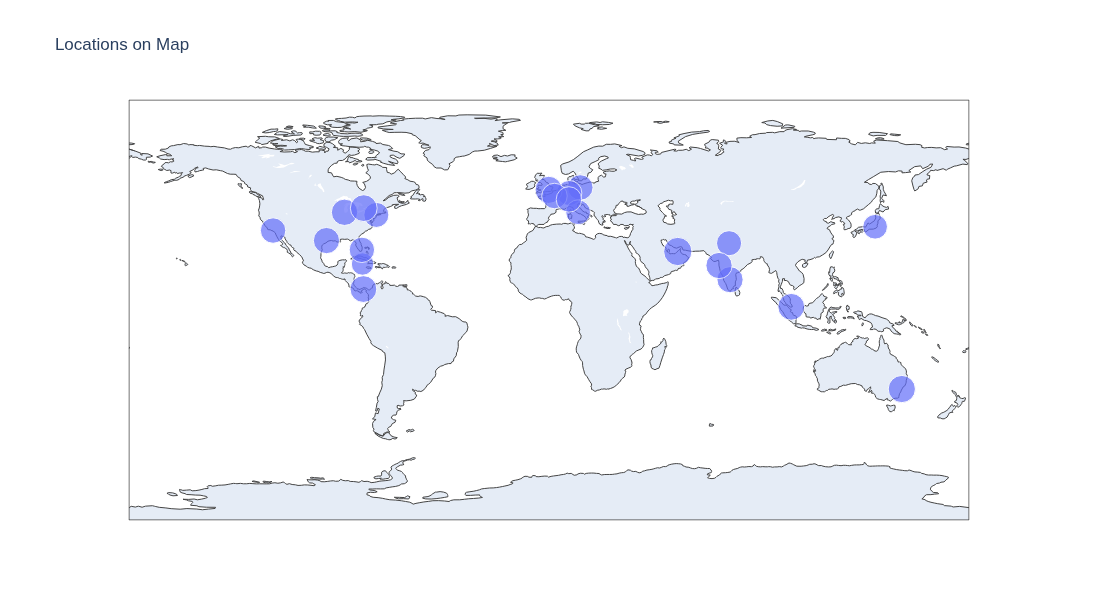

In [20]:
fig = px.scatter_geo(a,
                   lat='lat',
                   lon='long',
                   hover_name='location',
                   hover_data=['median_amount'],
                   title='Locations on Map', 
                   size = "median_amount",
                   width=1000, height=600
                )
fig.show()

### Show a heatmap of median amount (USD), by currency and purpose.

<Axes: xlabel='currency', ylabel='transaction_purpose'>

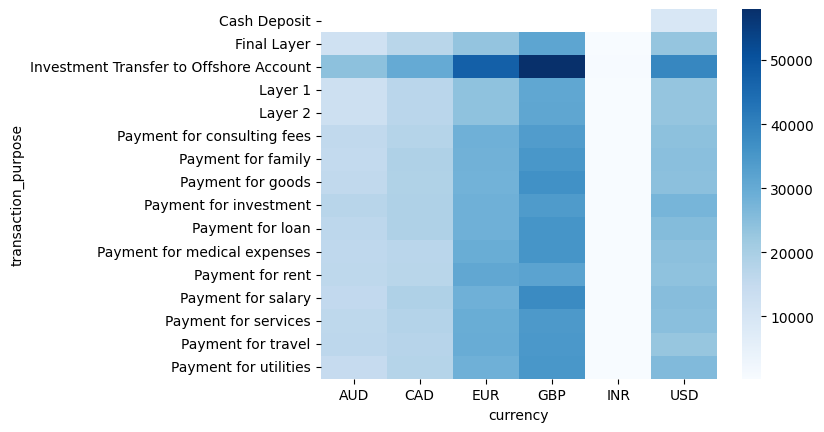

In [24]:
a = df.pivot_table("amount_usd", columns="currency", index="transaction_purpose")
sns.heatmap(a, cmap="Blues")

### Plot deposits and withdrawals over time to find any trend

<Axes: xlabel='timestamp'>

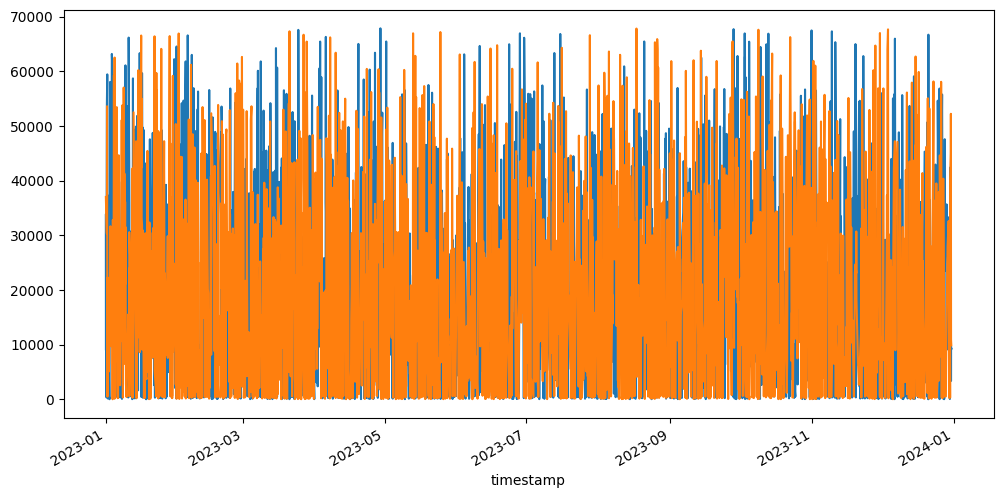

In [37]:
deposits = df[df.transaction_type == 'Deposit']["amount_usd"]
withdrawal = df[df.transaction_type == 'Withdrawal']["amount_usd"]
fig, ax = plt.subplots(figsize = (12, 6))
deposits.plot(ax = ax)
withdrawal.plot(ax = ax)

### Find average amount (USD) and count by each receiver_account_id. For each receiver account, find the currencies and transaction_types.

In [21]:
df.groupby("receiver_account_id").agg(
    avg_amount = ("amount_usd", "mean"), 
    count = ("amount_usd", "count"), 
    currencies = ("currency", set),
    # locations = ("location", set),
    transaction_types = ("transaction_type", set),
)

avg_amount  count                 currencies  \
receiver_account_id                                                   
ACC1001120607        16230.241067      3                 {EUR, AUD}   
ACC1003563577        15527.207140      5       {CAD, GBP, AUD, INR}   
ACC1012244063        24900.994800      2                 {EUR, AUD}   
ACC1018923235        10541.341000      2                 {CAD, AUD}   
ACC1025866100        28610.139414     10  {CAD, GBP, USD, INR, EUR}   
...                           ...    ...                        ...   
ACC9984079705        15223.644160      4       {EUR, GBP, USD, INR}   
ACC9984725416        23784.884380      5       {CAD, EUR, AUD, USD}   
ACC9986706305        29714.969075      4       {CAD, EUR, GBP, AUD}   
ACC9987362163        13314.627550      2                 {CAD, AUD}   
ACC9988276332        18082.236250      4       {CAD, GBP, AUD, USD}   

                                                     transaction_types  
receiver_account_id                                                     
ACC1001120607                      {Transfer, Loan Repayment, Deposit}  
ACC1003563577                          {Transfer, Withdrawal, Deposit}  
ACC1012244063                               {Online Purchase, Deposit}  
ACC1018923235                        {Online Purchase, Loan Repayment}  
ACC1025866100        {Bill Payment, Transfer, Loan Repayment, Withd...  
...                                                                ...  
ACC9984079705                              {Online Purchase, Transfer}  
ACC9984725416          {Transfer, Loan Repayment, Withdrawal, Deposit}  
ACC9986706305        {Bill Payment, Loan Repayment, Online Purchase...  
ACC9987362163                            {Online Purchase, Withdrawal}  
ACC9988276332              {Online Purchase, Transfer, Loan Repayment}  

[3073 rows x 4 columns]

# Suspecious Transactions

A small number of transactions are "suspicious" transactions by characteristics commonly associated with money laundering:

- Large, round sums: Transactions like \$9,999, \$10,000, \$50,000, etc
- Frequent transactions just below reporting thresholds: For example, multiple transactions of $9,500 if the threshold is $10,000.
- Transactions to/from high-risk countries: Though I won't create a comprehensive list, I can simulate some transactions involving less common or potentially high-risk locations.
- Rapid movement of funds between multiple accounts (layering): A sequence of transactions where money is quickly moved between several internal or external accounts.
- Unusual transaction times: Transactions occurring in the middle of the night or on weekends, especially for business accounts.
- Unusual transaction types for an account: e.g., a personal account suddenly making large international wire transfers.
- Multiple small deposits followed by a large withdrawal (structuring/smurfing).

## Large Transaction Amounts:

Heuristic: Individual transactions exceeding a predefined monetary threshold (e.g. USD 5,000) are often flagged for manual review, especially if they are cash transactions or international wires. In real-life, the threshold is calculated based on an individual's historical transactions or aggregated based on certain dimension such as jurisdiction. 

Rationale: Large sums are more likely to be associated with illicit activities. The threshold varies by jurisdiction and institution.

In [22]:
df_suspicious_large_amounts = df[df['amount'] >= 50000 | 
                ((df['transaction_type'] == 'Transfer') & (df['amount'] >= 10000))] # Adjust threshold
df_suspicious_large_amounts

transaction_id sender_account_id  \
timestamp                                                     
2023-01-01 01:30:33.350280     TXN0002457     ACC1499124175   
2023-01-01 01:58:08.773998     TXN0011184     ACC7416059279   
2023-01-01 02:15:07.201258     TXN0003728     ACC4160476591   
2023-01-01 03:14:20.956603     TXN0011215     ACC7829107700   
2023-01-01 03:21:08.832910     TXN0002454     ACC1273642132   
...                                   ...               ...   
2023-12-30 22:29:21.514150   TXN_S0001498     ACC6822622233   
2023-12-30 22:30:28.559025   TXN_S0012792     ACC9840333060   
2023-12-30 22:31:08.699832     TXN0001108     ACC6816347498   
2023-12-30 22:46:13.756359     TXN0000203     ACC1461645679   
2023-12-30 23:03:16.835771     TXN0010631     ACC6221555908   

                           receiver_account_id transaction_type    amount  \
timestamp                                                                   
2023-01-01 01:30:33.350280       ACC4315862424       Withdrawal  37024.07   
2023-01-01 01:58:08.773998       ACC9917457682          Deposit   6737.57   
2023-01-01 02:15:07.201258       ACC5192649511          Deposit  29729.13   
2023-01-01 03:14:20.956603       ACC1975423441     Bill Payment  30017.30   
2023-01-01 03:21:08.832910       ACC4601459057          Deposit   8322.98   
...                                        ...              ...       ...   
2023-12-30 22:29:21.514150       ACC6116709510          Deposit   9129.86   
2023-12-30 22:30:28.559025       ACC5315572453          Deposit   9179.38   
2023-12-30 22:31:08.699832       ACC6527084307  Online Purchase  22207.63   
2023-12-30 22:46:13.756359       ACC2586160833       Withdrawal  13527.96   
2023-12-30 23:03:16.835771       ACC9966716612   Loan Repayment  46476.10   

                           currency      sender_bank    receiver_bank  \
timestamp                                                               
2023-01-01 01:30:33.350280      USD           Bank B           Bank C   
2023-01-01 01:58:08.773998      GBP  Global Bank Co.           Bank C   
2023-01-01 02:15:07.201258      EUR           Bank C           Bank C   
2023-01-01 03:14:20.956603      EUR           Bank A  Global Bank Co.   
2023-01-01 03:21:08.832910      GBP   Universal Fin.           Bank C   
...                             ...              ...              ...   
2023-12-30 22:29:21.514150      USD           Bank B           Bank A   
2023-12-30 22:30:28.559025      USD           Bank C           Bank A   
2023-12-30 22:31:08.699832      AUD  Global Bank Co.   Universal Fin.   
2023-12-30 22:46:13.756359      CAD   Universal Fin.           Bank A   
2023-12-30 23:03:16.835771      EUR           Bank B           Bank C   

                               location           transaction_purpose  \
timestamp                                                               
2023-01-01 01:30:33.350280     New York            Payment for salary   
2023-01-01 01:58:08.773998       Mumbai  Payment for medical expenses   
2023-01-01 02:15:07.201258        Delhi          Payment for services   
2023-01-01 03:14:20.956603  Los Angeles        Payment for investment   
2023-01-01 03:21:08.832910       Mumbai   Payment for consulting fees   
...                                 ...                           ...   
2023-12-30 22:29:21.514150       Mumbai                  Cash Deposit   
2023-12-30 22:30:28.559025    Bengaluru                  Cash Deposit   
2023-12-30 22:31:08.699832       Sydney             Payment for goods   
2023-12-30 22:46:13.756359        Delhi              Payment for loan   
2023-12-30 23:03:16.835771      Chicago   Payment for consulting fees   

                            is_suspicious  amount_usd  
timestamp                                              
2023-01-01 01:30:33.350280          False  37024.0700  
2023-01-01 01:58:08.773998          False   9163.0952  
2023-01-01 02:15:07.201258          False  33891.2082  
2023-01-01 03:14:20.95660

## Structuring / Smurfing (Multiple Small Deposits/Withdrawals to Avoid Thresholds):

Multiple transactions from/to the same account, or a set of related accounts, for amounts just below a reporting threshold within a short period (e.g., 24 hours, 7 days).

Rationale: Criminals break down large sums into smaller ones to avoid detection.

In [23]:
# Sort by account and timestamp first
df_sorted = df.sort_values(by=['sender_account_id', 'timestamp'])

# Define a threshold (e.g., $10,000) and a window (e.g., 7 days)
THRESHOLD = 10000
WINDOW_DAYS = 7

suspicious_structuring_txns = pd.DataFrame()

for account_id in df_sorted['sender_account_id'].unique():
    account_txns = df_sorted[df_sorted['sender_account_id'] == account_id].copy()
    account_txns['amount_cummulative'] = account_txns['amount'].rolling(WINDOW_DAYS).sum()
    account_txns['num_txns_window'] = account_txns['transaction_id'].rolling(WINDOW_DAYS).count()

    # Flag if cumulative sum exceeds threshold and number of transactions is high
    # And individual transactions are below the threshold
    potential_smurfing = account_txns[
        (account_txns['amount_cummulative'] >= THRESHOLD) &
        (account_txns['num_txns_window'] > 1) &
        (account_txns['amount'] < THRESHOLD) # Individual transactions below threshold
    ]
    suspicious_structuring_txns = pd.concat([suspicious_structuring_txns, potential_smurfing])

suspicious_structuring_txns.reset_index(inplace = True)
suspicious_structuring_txns[['transaction_id', 'sender_account_id', 'amount', 'timestamp', 'amount_cummulative', 'num_txns_window']]

transaction_id sender_account_id   amount                  timestamp  \
0       TXN0012120     ACC1003563577  7430.88 2023-08-31 04:52:18.544038   
1       TXN0003002     ACC1003563577  3308.57 2023-11-20 11:17:18.219473   
2       TXN0006636     ACC1009703407  8800.48 2023-12-13 01:23:43.812291   
3       TXN0001739     ACC1009703407  6946.16 2023-12-19 11:36:06.392469   
4       TXN0003974     ACC1096217748  1522.94 2023-10-18 12:08:43.029711   
..             ...               ...      ...                        ...   
501     TXN0004185     ACC9891253201  7944.06 2023-07-18 06:25:09.714392   
502     TXN0008094     ACC9897656040  9853.38 2023-12-20 11:53:44.815679   
503   TXN_S0010673     ACC9908304293  9234.06 2023-09-10 11:14:19.636541   
504     TXN0000497     ACC9921583478  4354.47 2023-09-03 12:19:25.231900   
505     TXN0010809     ACC9949603264  1578.23 2023-12-27 07:24:20.638529   

     amount_cummulative  num_txns_window  
0             164081.26              7.0  
1             183591.44              7.0  
2             101484.67              7.0  
3              77766.39              7.0  
4             139343.33              7.0  
..                  ...              ...  
501           135820.41              7.0  
502           170428.69              7.0  
503           140022.69              7.0  
504           226094.07              7.0  
505           176263.36              7.0  

[506 rows x 6 columns]

## Transactions Involving High-Risk Jurisdictions/Locations:

Transfers to or from countries known for financial crime, tax evasion, or weak AML regulations.


Heuristic: Any transaction (especially high-value transfers) to or from countries identified as high-risk by financial intelligence units (FIUs) or international bodies.

Rationale: These locations may have weak AML regulations, be known tax havens, or be associated with specific illicit activities.



In [24]:
high_risk_locations = ['Panama City', 'Cayman Islands', 'Zurich', 'Dubai'] # Add more based on external lists
df_suspicious_locations = df[df['location'].isin(high_risk_locations)]
df_suspicious_locations

transaction_id sender_account_id  \
timestamp                                                     
2023-01-01 03:52:16.789690     TXN0007721     ACC7936885349   
2023-01-02 08:03:39.599183     TXN0002941     ACC8197291182   
2023-01-03 21:28:04.635855     TXN0006511     ACC6612424781   
2023-01-03 23:52:35.416326     TXN0008756     ACC3266080693   
2023-01-04 01:58:39.896496     TXN0010345     ACC9105941402   
...                                   ...               ...   
2023-12-29 15:20:18.206660     TXN0007403     ACC2318558870   
2023-12-29 19:32:20.980195     TXN0000189     ACC8721351533   
2023-12-30 00:50:19.552447     TXN0012614     ACC7811037365   
2023-12-30 09:41:47.855529     TXN0003362     ACC9794972907   
2023-12-30 17:46:56.271247     TXN0014399     ACC8847226107   

                           receiver_account_id transaction_type     amount  \
timestamp                                                                    
2023-01-01 03:52:16.789690       ACC3552665859     Bill Payment   10266.29   
2023-01-02 08:03:39.599183       ACC8577719385         Transfer  100000.00   
2023-01-03 21:28:04.635855       ACC7567052471         Transfer   49999.99   
2023-01-03 23:52:35.416326       ACC5837792153  Online Purchase    7983.86   
2023-01-04 01:58:39.896496       ACC8095723379         Transfer   13322.18   
...                                        ...              ...        ...   
2023-12-29 15:20:18.206660       ACC4094180666     Bill Payment   14425.89   
2023-12-29 19:32:20.980195       ACC9008633872          Deposit   12564.42   
2023-12-30 00:50:19.552447       ACC5861630852         Transfer   33903.36   
2023-12-30 09:41:47.855529       ACC1966876591         Transfer     281.79   
2023-12-30 17:46:56.271247       ACC8526313474          Deposit   35219.52   

                           currency      sender_bank    receiver_bank  \
timestamp                                                               
2023-01-01 03:52:16.789690      AUD           Bank C   Universal Fin.   
2023-01-02 08:03:39.599183      EUR  Global Bank Co.           Bank A   
2023-01-03 21:28:04.635855      INR  Global Bank Co.           Bank A   
2023-01-03 23:52:35.416326      INR  Global Bank Co.           Bank B   
2023-01-04 01:58:39.896496      INR  Global Bank Co.           Bank C   
...                             ...              ...              ...   
2023-12-29 15:20:18.206660      EUR           Bank C  Global Bank Co.   
2023-12-29 19:32:20.980195      EUR           Bank B   Universal Fin.   
2023-12-30 00:50:19.552447      CAD           Bank C           Bank A   
2023-12-30 09:41:47.855529      AUD           Bank B           Bank C   
2023-12-30 17:46:56.271247      CAD           Bank B  Global Bank Co.   

                                  location  \
timestamp                                    
2023-01-01 03:52:16.789690     Panama City   
2023-01-02 08:03:39.599183  Cayman Islands   
2023-01-03 21:28:04.635855     Panama City   
2023-01-03 23:52:35.416326     Panama City   
2023-01-04 01:58:39.896496          Zurich   
...                                    ...   
2023-12-29 15:20:18.206660          Zurich   
2023-12-29 19:32:20.980195          Zurich   
2023-12-30 00:50:19.552447          Zurich   
2023-12-30 09:41:47.855529  Cayman Islands   
2023-12-30 17:46:56.271247     Panama City   

                                                transaction_purpose  \
timestamp                                                             
2023-01-01 03:52:16.789690                   Payment for investment   
2023-01-02 08:03:39.599183  Investment Transfer to Offshore Account   
2023-01-03 21:28:04.635855  Investment Transfer to Offshore Account   
2023-01-03 23:52:35.416326              Payment for consulting fees   
2023-01-04 01:58:39.896496                     Payment for services   
...                                                             ...   
2023-12-29 15:20:18.206660                    Payment for utilities   
2023

# Unusual Transaction Times

Heuristic: Transactions occurring outside normal business hours for a business account, or an unusual burst of activity for any account. Consider, the time window between 10pm and 5am unusual. 

Rationale: Attempts to move money quickly or under the radar.


In [25]:
# Example: Transactions between 10 PM and 5 AM
df['hour'] = df.index.hour
df_suspicious_time = df[(df['hour'] >= 22) | (df['hour'] <= 5)]
df_suspicious_time

transaction_id sender_account_id  \
timestamp                                                     
2023-01-01 01:30:33.350280     TXN0002457     ACC1499124175   
2023-01-01 01:58:08.773998     TXN0011184     ACC7416059279   
2023-01-01 02:15:07.201258     TXN0003728     ACC4160476591   
2023-01-01 03:14:20.956603     TXN0011215     ACC7829107700   
2023-01-01 03:21:08.832910     TXN0002454     ACC1273642132   
...                                   ...               ...   
2023-12-30 22:29:21.514150   TXN_S0001498     ACC6822622233   
2023-12-30 22:30:28.559025   TXN_S0012792     ACC9840333060   
2023-12-30 22:31:08.699832     TXN0001108     ACC6816347498   
2023-12-30 22:46:13.756359     TXN0000203     ACC1461645679   
2023-12-30 23:03:16.835771     TXN0010631     ACC6221555908   

                           receiver_account_id transaction_type    amount  \
timestamp                                                                   
2023-01-01 01:30:33.350280       ACC4315862424       Withdrawal  37024.07   
2023-01-01 01:58:08.773998       ACC9917457682          Deposit   6737.57   
2023-01-01 02:15:07.201258       ACC5192649511          Deposit  29729.13   
2023-01-01 03:14:20.956603       ACC1975423441     Bill Payment  30017.30   
2023-01-01 03:21:08.832910       ACC4601459057          Deposit   8322.98   
...                                        ...              ...       ...   
2023-12-30 22:29:21.514150       ACC6116709510          Deposit   9129.86   
2023-12-30 22:30:28.559025       ACC5315572453          Deposit   9179.38   
2023-12-30 22:31:08.699832       ACC6527084307  Online Purchase  22207.63   
2023-12-30 22:46:13.756359       ACC2586160833       Withdrawal  13527.96   
2023-12-30 23:03:16.835771       ACC9966716612   Loan Repayment  46476.10   

                           currency      sender_bank    receiver_bank  \
timestamp                                                               
2023-01-01 01:30:33.350280      USD           Bank B           Bank C   
2023-01-01 01:58:08.773998      GBP  Global Bank Co.           Bank C   
2023-01-01 02:15:07.201258      EUR           Bank C           Bank C   
2023-01-01 03:14:20.956603      EUR           Bank A  Global Bank Co.   
2023-01-01 03:21:08.832910      GBP   Universal Fin.           Bank C   
...                             ...              ...              ...   
2023-12-30 22:29:21.514150      USD           Bank B           Bank A   
2023-12-30 22:30:28.559025      USD           Bank C           Bank A   
2023-12-30 22:31:08.699832      AUD  Global Bank Co.   Universal Fin.   
2023-12-30 22:46:13.756359      CAD   Universal Fin.           Bank A   
2023-12-30 23:03:16.835771      EUR           Bank B           Bank C   

                               location           transaction_purpose  \
timestamp                                                               
2023-01-01 01:30:33.350280     New York            Payment for salary   
2023-01-01 01:58:08.773998       Mumbai  Payment for medical expenses   
2023-01-01 02:15:07.201258        Delhi          Payment for services   
2023-01-01 03:14:20.956603  Los Angeles        Payment for investment   
2023-01-01 03:21:08.832910       Mumbai   Payment for consulting fees   
...                                 ...                           ...   
2023-12-30 22:29:21.514150       Mumbai                  Cash Deposit   
2023-12-30 22:30:28.559025    Bengaluru                  Cash Deposit   
2023-12-30 22:31:08.699832       Sydney             Payment for goods   
2023-12-30 22:46:13.756359        Delhi              Payment for loan   
2023-12-30 23:03:16.835771      Chicago   Payment for consulting fees   

                            is_suspicious  amount_usd  hour  
timestamp                                                    
2023-01-01 01:30:33.350280          False  37024.0700     1  
2023-01-01 01:58:08.773998          False   9163.0952     1  
2023-01-01 02:15:07.201258          False  33891.2082    

## Rapid Movement of Funds (Layering - Initial Stage):

Heuristic: Funds deposited into an account and then quickly (e.g. < 1 hour) withdrawn or transferred out to another account, especially with little or no economic purpose.

Rationale: This is a core part of money laundering to obscure the source of funds.



In [26]:
# This is a very basic attempt. Graph is far superior for this.
# Look for scenarios where A sends to B, and shortly after B sends to C or A.
# Requires self-joins or complex grouping.


# Sort by timestamp
df_time_sorted = df.reset_index().sort_values('timestamp')

suspicious_layering_txns = []

# Iterate through transactions to find sequences
for i in range(len(df_time_sorted) - 1):
    txn1 = df_time_sorted.iloc[i]
    # Look for subsequent transactions from txn1's receiver or to txn1's sender
    # within a short time window (e.g., 1 hour)
    potential_next_txns = df_time_sorted[
        (df_time_sorted['timestamp'] > txn1['timestamp']) &
        (df_time_sorted['timestamp'] <= txn1['timestamp'] + timedelta(hours=1)) &
        ((df_time_sorted['sender_account_id'] == txn1['receiver_account_id']) |
         (df_time_sorted['receiver_account_id'] == txn1['sender_account_id'])) # A->B then B->C OR A->B then C->A
    ]

    for j, txn2 in potential_next_txns.iterrows():
        # Simple chain A -> B -> C where B is the intermediary
        if txn1['receiver_account_id'] == txn2['sender_account_id'] and txn1['sender_account_id'] != txn2['receiver_account_id']:
            # Consider if amounts are similar or full amount is moved
            if abs(txn1['amount'] - txn2['amount']) / txn1['amount'] < 0.1: # Amounts are within 10%
                suspicious_layering_txns.append(txn1['transaction_id'])
                suspicious_layering_txns.append(txn2['transaction_id'])
        # Consider A -> B then C -> A (round tripping)
        elif txn1['receiver_account_id'] == txn2['receiver_account_id'] and txn1['sender_account_id'] == txn2['sender_account_id']:
            pass # This is not layering, likely same person moving money between their own accounts
        elif txn1['sender_account_id'] == txn2['receiver_account_id'] and txn1['receiver_account_id'] == txn2['sender_account_id']:
            pass # This is direct A <-> B reversal or repeat transaction

df_susp_layering = df[df['transaction_id'].isin(suspicious_layering_txns)].reset_index()
df_susp_layering[['transaction_id', 'timestamp', 'sender_account_id', 'receiver_account_id', 'amount']]

transaction_id                  timestamp sender_account_id  \
0     TXN_L0000688 2023-01-18 04:07:35.659022     ACC4150427588   
1     TXN_L0000690 2023-01-18 04:26:35.659022     ACC3838243576   
2     TXN_L0000692 2023-01-18 04:43:35.659022     ACC2759200693   
3     TXN_L0011837 2023-01-28 16:31:28.724922     ACC8619868641   
4     TXN_L0011839 2023-01-28 16:44:28.724922     ACC1323172860   
..             ...                        ...               ...   
122   TXN_L0000915 2023-12-20 13:42:53.707163     ACC6073332231   
123   TXN_L0000917 2023-12-20 13:47:53.707163     ACC8475913514   
124   TXN_L0000919 2023-12-20 14:20:53.707163     ACC9493418530   
125   TXN_L0005018 2023-12-22 08:45:50.618445     ACC4806342816   
126   TXN_L0005020 2023-12-22 09:00:50.618445     ACC5201191995   

    receiver_account_id        amount  
0         ACC3838243576  22617.840000  
1         ACC2759200693  22268.919734  
2         ACC3482554375  23041.113910  
3         ACC1323172860  24759.980000  
4         ACC2007580439  25170.317154  
..                  ...           ...  
122       ACC8475913514  24476.860000  
123       ACC9493418530  24287.638678  
124       ACC5596947973  24473.809123  
125       ACC5201191995  23879.510000  
126       ACC4448900656  23874.852396  

[127 rows x 5 columns]

## Unusual Transaction Patterns for a Given Account/Customer Profile:

A sudden change in transaction frequency, average amount, or types of transactions for a specific account. This often requires historical data and baselining.

In [27]:
# Find threshold using the last day of the seconda last month in the whole dataset

from pandas.tseries.offsets import MonthEnd

date_threshold = df.index.to_period("M").unique().sort_values()[-2].to_timestamp() + MonthEnd()
date_threshold

Timestamp('2023-11-30 00:00:00')

In [28]:
# Example: Find accounts with significantly higher number of transactions this month vs. average
df['month'] = df.index.month
monthly_txn_counts_baseline = df[df.index<=date_threshold].groupby(['sender_account_id', 'month']).agg(
            transaction_count = ("transaction_id", "count"), 
            types = ("transaction_type", set),
            amount_mean = ("amount_usd", "mean")
).reset_index()
# Further analysis would involve calculating average counts and identifying outliers.
monthly_txn_counts_baseline

sender_account_id  month  transaction_count  \
0         ACC1001120607      5                  1   
1         ACC1001120607      8                  1   
2         ACC1001120607     10                  2   
3         ACC1001120607     11                  2   
4         ACC1003563577      3                  1   
...                 ...    ...                ...   
11366     ACC9988276332      1                  1   
11367     ACC9988276332      4                  1   
11368     ACC9988276332      5                  1   
11369     ACC9988276332      7                  1   
11370     ACC9988276332      8                  1   

                              types  amount_mean  
0                         {Deposit}   46827.7800  
1                      {Withdrawal}   27207.1374  
2      {Loan Repayment, Withdrawal}   40965.7370  
3            {Transfer, Withdrawal}   39285.5628  
4                         {Deposit}    2616.4733  
...                             ...          ...  
11366                {Bill Payment}    7463.4470  
11367              {Loan Repayment}   20626.1900  
11368                     {Deposit}   23430.8319  
11369             {Online Purchase}   53911.6376  
11370                    {Transfer}   22305.9400  

[11371 rows x 5 columns]

In [29]:
# Average number of transactions per sender_account_id 

threshold_by_sender_account_id = monthly_txn_counts_baseline.groupby("sender_account_id")["transaction_count"].agg(["mean", "std"])
threshold_by_sender_account_id["threshold"] = threshold_by_sender_account_id["mean"] + 3 * threshold_by_sender_account_id["std"]
threshold_by_sender_account_id

mean       std  threshold
sender_account_id                           
ACC1001120607      1.50  0.577350   3.232051
ACC1003563577      2.40  2.073644   8.620932
ACC1009703407      1.20  0.447214   2.541641
ACC1012244063      2.00  1.414214   6.242641
ACC1018923235      1.00  0.000000   1.000000
...                 ...       ...        ...
ACC9984079705      1.50  0.707107   3.621320
ACC9984725416      1.25  0.500000   2.750000
ACC9986706305      1.25  0.500000   2.750000
ACC9987362163      1.00  0.000000   1.000000
ACC9988276332      1.00  0.000000   1.000000

[3049 rows x 3 columns]

In [30]:
threshold_by_sender_account_id_map = threshold_by_sender_account_id["threshold"].to_dict()
str(threshold_by_sender_account_id_map)[:500]

"{'ACC1001120607': 3.232050807568877, 'ACC1003563577': 8.620932405998316, 'ACC1009703407': 2.541640786499874, 'ACC1012244063': 6.242640687119286, 'ACC1018923235': 1.0, 'ACC1025866100': 1.0, 'ACC1027903865': 1.0, 'ACC1029147654': 1.0, 'ACC1029811053': 1.0, 'ACC1031450478': 1.0, 'ACC1033962977': 1.0, 'ACC1034028671': 1.0, 'ACC1036513174': 3.232050807568877, 'ACC1036965373': 3.0653841409022107, 'ACC1040400421': 2.75, 'ACC1042069004': 1.0, 'ACC1048119098': 3.0653841409022107, 'ACC1051001577': nan, 'A"

In [31]:
monthly_txn_counts = df[df.index > date_threshold].groupby(['sender_account_id', 'month']).agg(
            transaction_count = ("transaction_id", "count"), 
            types = ("transaction_type", set),
            amount_mean = ("amount_usd", "mean")
)
monthly_txn_counts = monthly_txn_counts[monthly_txn_counts["transaction_count"]  > 1].reset_index()
monthly_txn_counts["threshold"] = monthly_txn_counts["sender_account_id"].map(threshold_by_sender_account_id_map)
unusual_frequency_agg = monthly_txn_counts.query("(transaction_count>threshold) and (threshold>3)")
unusual_frequency_agg

sender_account_id  month  transaction_count  \
8       ACC1411679070     12                  4   
11      ACC1600706607     12                  6   
181     ACC9821816904     12                  4   

                               types  amount_mean  threshold  
8                {Transfer, Deposit}    8471.6998   3.043168  
11           {Bill Payment, Deposit}    8741.0367   4.622281  
181  {Transfer, Withdrawal, Deposit}   11475.1020   3.232051

In [32]:
a = df.reset_index()
unusual_transaction_frequency = pd.merge(a[a["timestamp"] > date_threshold], 
         unusual_frequency_agg, 
         left_on=("sender_account_id", "month"), 
         right_on=("sender_account_id", "month"), 
         how = "inner").sort_values("timestamp")
unusual_transaction_frequency

timestamp transaction_id sender_account_id  \
0  2023-12-03 15:25:24.326794     TXN0004656     ACC9821816904   
1  2023-12-08 06:41:40.861000     TXN0008641     ACC9821816904   
2  2023-12-08 07:05:40.861000   TXN_S0008939     ACC9821816904   
3  2023-12-08 07:22:40.861000   TXN_S0008940     ACC9821816904   
4  2023-12-09 04:30:35.804314     TXN0013561     ACC1411679070   
5  2023-12-09 04:35:35.804314   TXN_S0014031     ACC1411679070   
6  2023-12-09 04:52:35.804314   TXN_S0014030     ACC1411679070   
7  2023-12-09 06:08:35.804314   TXN_S0014029     ACC1411679070   
8  2023-12-29 12:59:30.299877     TXN0000601     ACC1600706607   
9  2023-12-29 13:09:30.299877   TXN_S0000625     ACC1600706607   
10 2023-12-29 13:51:30.299877   TXN_S0000627     ACC1600706607   
11 2023-12-29 13:58:30.299877   TXN_S0000623     ACC1600706607   
12 2023-12-29 14:08:30.299877   TXN_S0000624     ACC1600706607   
13 2023-12-29 15:28:30.299877   TXN_S0000626     ACC1600706607   

   receiver_account_id transaction_type    amount currency      sender_bank  \
0        ACC7445338583         Transfer  34364.52      AUD  Global Bank Co.   
1        ACC7829107700       Withdrawal   4107.51      USD           Bank B   
2        ACC6467744000          Deposit   9885.63      USD           Bank B   
3        ACC6886420016          Deposit   9570.33      USD           Bank B   
4        ACC3689671193         Transfer   3855.97      GBP  Global Bank Co.   
5        ACC8263587630          Deposit   9175.11      USD  Global Bank Co.   
6        ACC2592648595          Deposit   9641.94      USD  Global Bank Co.   
7        ACC3567377184          Deposit   9825.63      USD  Global Bank Co.   
8        ACC5622213260     Bill Payment   4304.43      EUR           Bank A   
9        ACC8104157469          Deposit   9740.27      USD           Bank A   
10       ACC1098446303          Deposit   9461.35      USD           Bank A   
11       ACC1766018717          Deposit   9827.10      USD           Bank A   
12       ACC7045924827          Deposit   9460.02      USD           Bank A   
13       ACC8208493717          Deposit   9050.43      USD           Bank A   

     receiver_bank     location           transaction_purpose  is_suspicious  \
0   Universal Fin.       London          Payment for services          False   
1           Bank B    Bengaluru  Payment for medical expenses           True   
2           Bank A        Miami                  Cash Deposit           True   
3           Bank A  Los Angeles                  Cash Deposit           True   
4           Bank A     New York          Payment for services           True   
5           Bank A        Miami                  Cash Deposit           True   
6           Bank A     New York                  Cash Deposit           True   
7           Bank A      Chicago                  Cash Deposit           True   
8   Universal Fin.      Toronto   Payment for consulting fees           True   
9           Bank A        Delhi                  Cash Deposit           True   
10          Bank A      Chicago                  Cash Deposit           True   
11          Bank A    Bengaluru                  Cash Deposit           True   
12          Bank A  Los Angeles                  Cash Deposit           True   
13          Bank A        Delhi                  Cash Deposit           True   

    amount_usd  hour  month  transaction_count  \
0   22336.9380    15     12                  4   
1    4107.5100     6     12                  4   
2    9885.6300     7     12                  4   
3    9570.3300     7     12                  4   
4    5244.1192     4     12                  4   
5    9175.1100     4     12                  4   
6    9641.9400     4     12                  4   
7    9825.6300     6     12                  4   
8    4907.0502    12     12                  6   
9    9740.2700    13     12                  6   
10   9461.3500    13     12                  6   
11   9827.1000    13     12               

## Impossible Travel

More than one "Withdrawal" or "Deposit" transactions are found from more than one locations - within a time frame shorter than the physical duration of travel is a strong indicator of potential fradulent trasactions. Assuming that Withdrawal and Deposit require physical presence of the account holder, it is pracitically not possible to be present in two different cities like London and Mumbai within a matter of 3 hours. 

Transaction types are: ['Withdrawal', 'Deposit', 'Bill Payment', 'Online Purchase',
       'Loan Repayment', 'Transfer']

In [33]:
df["timestamp_h"] = df.index.to_period("3h")
a = df[df["transaction_type"].isin(('Withdrawal', 'Deposit'))]\
    .groupby(["sender_account_id", "timestamp_h"])\
    .agg(locations = ('location', set), transaction_ids = ('transaction_id', list))\
    .reset_index()
impossible_travel = a[a["locations"].apply(len)>1]
impossible_travel

sender_account_id       timestamp_h                         locations  \
5        ACC1003563577  2023-06-10 14:00         {Bengaluru, Miami, Delhi}   
75       ACC1133082707  2023-01-15 14:00                  {Houston, Delhi}   
77       ACC1133082707  2023-03-19 02:00              {Los Angeles, Miami}   
93       ACC1170485310  2023-06-04 02:00                  {Houston, Delhi}   
94       ACC1170485310  2023-06-04 03:00             {Bengaluru, New York}   
...                ...               ...                               ...   
4766     ACC9419638840  2023-08-25 14:00  {Los Angeles, Houston, New York}   
4990     ACC9764219292  2023-04-17 05:00       {Bengaluru, Houston, Delhi}   
5018     ACC9794972907  2023-04-16 14:00            {Los Angeles, Chicago}   
5020     ACC9794972907  2023-04-16 16:00             {Bengaluru, New York}   
5051     ACC9821816904  2023-12-08 07:00              {Los Angeles, Miami}   

                                 transaction_ids  
5     [TXN_S0002863, TXN_S0002862, TXN_S0002864]  
75    [TXN_S0003729, TXN_S0003730, TXN_S0003731]  
77                  [TXN_S0001251, TXN_S0001250]  
93                  [TXN_S0011670, TXN_S0011673]  
94                  [TXN_S0011674, TXN_S0011671]  
...                                          ...  
4766    [TXN0005641, TXN_S0005847, TXN_S0005849]  
4990  [TXN_S0011545, TXN_S0011542, TXN_S0011544]  
5018                [TXN_S0014899, TXN_S0014901]  
5020                [TXN_S0014897, TXN_S0014900]  
5051                [TXN_S0008939, TXN_S0008940]  

[97 rows x 4 columns]

In [34]:
a = df.reset_index()
b = impossible_travel.explode("transaction_ids")
b = b.rename(columns = {"transaction_ids": "transaction_id"})
impossible_transactions = pd.merge(a, b, on="transaction_id")
impossible_transactions

timestamp transaction_id sender_account_id_x  \
0   2023-01-05 10:29:08.206393   TXN_S0014527       ACC3099347749   
1   2023-01-05 10:53:08.206393   TXN_S0014526       ACC3099347749   
2   2023-01-05 14:01:25.011264   TXN_S0003604       ACC1207276356   
3   2023-01-05 14:44:25.011264   TXN_S0003605       ACC1207276356   
4   2023-01-09 12:03:39.230122   TXN_S0010801       ACC7003266445   
..                         ...            ...                 ...   
220 2023-12-29 13:09:30.299877   TXN_S0000625       ACC1600706607   
221 2023-12-29 13:51:30.299877   TXN_S0000627       ACC1600706607   
222 2023-12-29 13:58:30.299877   TXN_S0000623       ACC1600706607   
223 2023-12-30 20:08:21.514150   TXN_S0001496       ACC6822622233   
224 2023-12-30 20:19:21.514150   TXN_S0001495       ACC6822622233   

    receiver_account_id transaction_type   amount currency     sender_bank  \
0         ACC4006836387          Deposit  9137.65      USD          Bank A   
1         ACC8073401695          Deposit  9845.20      USD          Bank A   
2         ACC9357773988          Deposit  9964.39      USD  Universal Fin.   
3         ACC3502284367          Deposit  9602.44      USD  Universal Fin.   
4         ACC2068709475          Deposit  9321.35      USD  Universal Fin.   
..                  ...              ...      ...      ...             ...   
220       ACC8104157469          Deposit  9740.27      USD          Bank A   
221       ACC1098446303          Deposit  9461.35      USD          Bank A   
222       ACC1766018717          Deposit  9827.10      USD          Bank A   
223       ACC4219197935          Deposit  9633.82      USD          Bank B   
224       ACC2666939424          Deposit  9639.07      USD          Bank B   

    receiver_bank     location transaction_purpose  is_suspicious  amount_usd  \
0          Bank A    Bengaluru        Cash Deposit           True     9137.65   
1          Bank A  Los Angeles        Cash Deposit           True     9845.20   
2          Bank A    Bengaluru        Cash Deposit           True     9964.39   
3          Bank A  Los Angeles        Cash Deposit           True     9602.44   
4          Bank A        Miami        Cash Deposit           True     9321.35   
..            ...          ...                 ...            ...         ...   
220        Bank A        Delhi        Cash Deposit           True     9740.27   
221        Bank A      Chicago        Cash Deposit           True     9461.35   
222        Bank A    Bengaluru        Cash Deposit           True     9827.10   
223        Bank A      Chicago        Cash Deposit           True     9633.82   
224        Bank A  Los Angeles        Cash Deposit           True     9639.07   

     hour  month     timestamp_h_x sender_account_id_y     timestamp_h_y  \
0      10      1  2023-01-05 10:00       ACC3099347749  2023-01-05 10:00   
1      10      1  2023-01-05 10:00       ACC3099347749  2023-01-05 10:00   
2      14      1  2023-01-05 14:00       ACC1207276356  2023-01-05 14:00   
3      14      1  2023-01-05 14:00       ACC1207276356  2023-01-05 14:00   
4      12      1  2023-01-09 12:00       ACC7003266445  2023-01-09 12:00   
..    ...    ...               ...                 ...               ...   
220    13     12  2023-12-29 13:00       ACC1600706607  2023-12-29 13:00   
221    13     12  2023-12-29 13:00       ACC1600706607  2023-12-29 13:00   
222    13     12  2023-12-29 13:00       ACC1600706607  2023-12-29 13:00   
223    20     12  2023-12-30 20:00       ACC6822622233  2023-12-30 20:00   
224    20     12  2023-12-30 20:00       ACC6822622233  2023-12-30 20:00   

                       locations  
0       {Los Angeles, Bengaluru}  
1       {Los Angeles, Bengaluru}  
2       {Los Angeles, Bengaluru}  
3       {Los Angeles, Bengaluru}  
4               {Miami, Chicago}  
..                           ...  
220  {Bengaluru, Chicago, Delhi}  
221  {Bengaluru, Chicago, Delhi}  
222  {Bengaluru, Chicago, Delhi}  
223       {Los Ange

# AML Heuristics using customer data


Let's load customer data

In [25]:
df_transactions = pd.read_csv('synthetic_banking_transactions.csv')

df_transactions["timestamp"] = pd.to_datetime(df_transactions['timestamp'])
# df_transactions.set_index("timestamp", inplace=True)
df_transactions["amount_usd"] = df_transactions["amount"] * df_transactions["currency"].map(currency_rate)


df_customers = pd.read_csv('synthetic_customer_data.csv')

# Link transaction data to sender customer profile
df_transactions_enriched = df_transactions.merge(
    df_customers,
    left_on='sender_account_id',
    right_on='account_id',
    how='left', # Use left join to keep all transactions
    suffixes=('_txn', '_sender')
)

# You might want to merge again for receiver customer profile if needed
# For now, let's just focus on sender's profile for examples
df_transactions_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15518 entries, 0 to 15517
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_id       15518 non-null  object        
 1   timestamp            15518 non-null  datetime64[ns]
 2   sender_account_id    15518 non-null  object        
 3   receiver_account_id  15518 non-null  object        
 4   transaction_type     15518 non-null  object        
 5   amount               15518 non-null  float64       
 6   currency             15518 non-null  object        
 7   sender_bank          15518 non-null  object        
 8   receiver_bank        15518 non-null  object        
 9   location             15518 non-null  object        
 10  transaction_purpose  15518 non-null  object        
 11  is_suspicious        15518 non-null  bool          
 12  amount_usd           15518 non-null  float64       
 13  customer_id          12541 non-

In [26]:
df_transactions_enriched.head()

transaction_id                  timestamp sender_account_id  \
0     TXN0002457 2023-01-01 01:30:33.350280     ACC1499124175   
1     TXN0011184 2023-01-01 01:58:08.773998     ACC7416059279   
2     TXN0003728 2023-01-01 02:15:07.201258     ACC4160476591   
3     TXN0011215 2023-01-01 03:14:20.956603     ACC7829107700   
4     TXN0002454 2023-01-01 03:21:08.832910     ACC1273642132   

  receiver_account_id transaction_type    amount currency      sender_bank  \
0       ACC4315862424       Withdrawal  37024.07      USD           Bank B   
1       ACC9917457682          Deposit   6737.57      GBP  Global Bank Co.   
2       ACC5192649511          Deposit  29729.13      EUR           Bank C   
3       ACC1975423441     Bill Payment  30017.30      EUR           Bank A   
4       ACC4601459057          Deposit   8322.98      GBP   Universal Fin.   

     receiver_bank     location  ... marital_status  number_of_children  \
0           Bank C     New York  ...       Divorced                 0.0   
1           Bank C       Mumbai  ...            NaN                 NaN   
2           Bank C        Delhi  ...       Divorced                 4.0   
3  Global Bank Co.  Los Angeles  ...         Single                 3.0   
4           Bank C       Mumbai  ...       Divorced                 2.0   

   annual_income_usd   source_of_wealth house_ownership credit_score  \
0            66571.0            Savings       Mortgaged        637.0   
1                NaN                NaN             NaN          NaN   
2            79241.0  Real Estate Sales       Mortgaged        692.0   
3            41817.0            Savings       Mortgaged        319.0   
4            54305.0         Employment           Owned        664.0   

  customer_since risk_category pep_status sanction_status  
0     2014-08-11        Medium      False           False  
1            NaN           NaN        NaN             NaN  
2     2012-05-08           Low      False           False  
3     2022-06-17           Low      False           False  
4     2013-05-17           Low      False           False  

[5 rows x 31 columns]

### Show a correlation between credit_score and amount (USD). Use scatter plot or jointplot.

Explore hexbin plot: Hexbins can also handle very large datasets with millions of points efficiently. Some key advantages of hexagonal binning plots include: Reduces sampling bias and visual distortions compared to rectangular bins. Effective for spatial data visualization and identifying clusters.


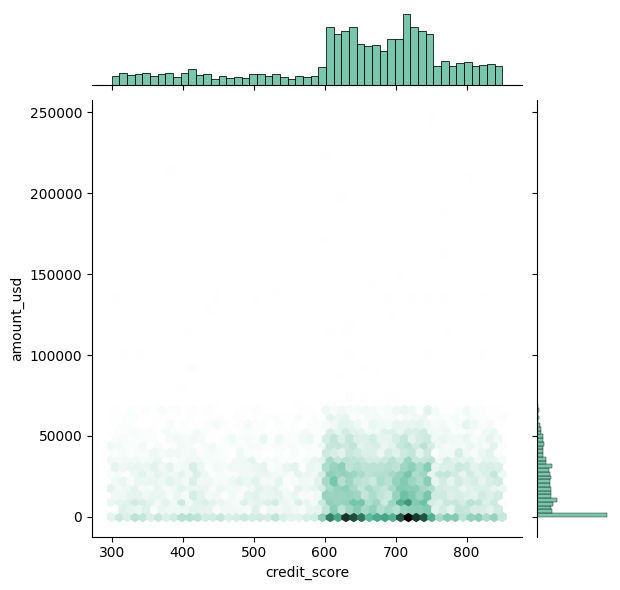

In [29]:
sns.jointplot(df_transactions_enriched, x = "credit_score", y = "amount_usd", kind="hex", color="#4CB391")

## Transaction Amount vs. Declared Income/Occupation



**Heuristic**: A customer making or receiving transactions (especially deposits or large transfers) that are significantly disproportionate to their declared annual income or typical income for their occupation.

**Rationale**: A key indicator of unexplained wealth or illicit funds.

    

In [36]:
# Filter for transactions where amount is a large percentage of annual income (e.g., > 20% in a single txn)
df_susp_income_discrepancy = df_transactions_enriched[
    (df_transactions_enriched['amount_usd'] > (df_transactions_enriched['annual_income_usd'] * 0.20)) &
    (df_transactions_enriched['transaction_type'].isin(['Deposit', 'Transfer']))
]
df_susp_income_discrepancy[['transaction_id', 'sender_account_id', 
                            'full_name', 'occupation', 'annual_income_usd', 
                            'amount', 'transaction_type']]

transaction_id sender_account_id     full_name  \
2         TXN0003728     ACC4160476591      Dawn Ray   
4         TXN0002454     ACC1273642132    David Leon   
15        TXN0006425     ACC4753450736  Kristen Tran   
27        TXN0013759     ACC9153706443  Jerry Greene   
36        TXN0010175     ACC2169908047  Laura Gibson   
...              ...               ...           ...   
15508   TXN_S0001497     ACC6822622233   Cole Miller   
15511   TXN_S0012791     ACC9840333060    Drew Lewis   
15512   TXN_S0012790     ACC9840333060    Drew Lewis   
15513   TXN_S0001498     ACC6822622233   Cole Miller   
15514   TXN_S0012792     ACC9840333060    Drew Lewis   

                     occupation  annual_income_usd    amount transaction_type  
2                     Scientist            79241.0  29729.13          Deposit  
4                         Nurse            54305.0   8322.98          Deposit  
15          Government Employee            94452.0  46536.97         Transfer  
27            Real Estate Agent            80918.0  47112.55          Deposit  
36     Self-Employed Consultant           149001.0  43630.73         Transfer  
...                         ...                ...       ...              ...  
15508            Police Officer            38343.0   9167.55          Deposit  
15511                Unemployed             7169.0   9512.84          Deposit  
15512                Unemployed             7169.0   9177.97          Deposit  
15513            Police Officer            38343.0   9129.86          Deposit  
15514                Unemployed             7169.0   9179.38          Deposit  

[2309 rows x 7 columns]

## PEP (Politically Exposed Person) Transactions:

**Heuristic:** Any transaction involving a Politically Exposed Person (PEP) requires heightened scrutiny, regardless of amount. PEPs are at higher risk for bribery and corruption.

**Rationale:** Regulatory requirement for enhanced due diligence.

In [37]:
df_susp_pep = df_transactions_enriched[df_transactions_enriched['pep_status'] == True]
df_susp_pep[['transaction_id', 'sender_account_id', 'full_name', 'occupation', 'pep_status', 'amount_usd']]

transaction_id sender_account_id            full_name  occupation  \
23        TXN0006950     ACC7356692033  Michael Bradshaw IV  Politician   
80        TXN0002941     ACC8197291182         Rhonda Jones  Politician   
117       TXN0001491     ACC1293848955       Nicole Fleming  Politician   
144       TXN0014434     ACC3502284367           Anna Smith  Politician   
190       TXN0014041     ACC3099347749       Andrew Edwards  Politician   
...              ...               ...                  ...         ...   
15399     TXN0008049     ACC2474045401        Stephanie Day  Politician   
15445     TXN0010267     ACC6463575697       Timothy Mendez  Politician   
15448     TXN0001243     ACC6534673007         April Garcia  Politician   
15461     TXN0003592     ACC9638401929      Stephanie Smith  Politician   
15515     TXN0001108     ACC6816347498       Benjamin Adams  Politician   

      pep_status    amount_usd  
23          True   23375.48330  
80          True  114000.00000  
117         True   36748.35000  
144         True   57067.72160  
190         True    3899.90580  
...          ...           ...  
15399       True   18416.50000  
15445       True   16080.42960  
15448       True    4216.84250  
15461       True     292.32624  
15515       True   14434.95950  

[785 rows x 6 columns]

## Sanctioned Individual Transactions:

**Heuristic:** Any transaction involving an individual on a sanctions list (e.g., OFAC, UN sanctions). This is a hard stop and reportable offense.

**Rationale:** Legal and regulatory prohibition.

In [38]:
df_susp_sanctioned = df_transactions_enriched[df_transactions_enriched['sanction_status'] == True]

df_susp_sanctioned[['transaction_id', 'sender_account_id', 'full_name', 'sanction_status', 'amount_usd']]

transaction_id sender_account_id             full_name sanction_status  \
2604      TXN0000622     ACC5830915277      David Cunningham            True   
3092      TXN0007660     ACC5810663108        Melissa Larson            True   
3310      TXN0003622     ACC5810663108        Melissa Larson            True   
5096      TXN0000939     ACC1902147982  Christopher Peterson            True   
5341      TXN0005886     ACC5830915277      David Cunningham            True   
5382    TXN_L0002519     ACC5490440955        Monica Johnson            True   
5426      TXN0014548     ACC6260919169            Paul Velez            True   
6186      TXN0014256     ACC5830915277      David Cunningham            True   
8294      TXN0011869     ACC5830915277      David Cunningham            True   
8302      TXN0003502     ACC5830915277      David Cunningham            True   
9548      TXN0008941     ACC5810663108        Melissa Larson            True   
9719      TXN0001202     ACC5830915277      David Cunningham            True   
10113     TXN0001590     ACC1902147982  Christopher Peterson            True   
10787     TXN0003415     ACC6260919169            Paul Velez            True   
12243     TXN0008347     ACC6260919169            Paul Velez            True   
12535     TXN0012857     ACC1902147982  Christopher Peterson            True   
12708     TXN0013052     ACC5810663108        Melissa Larson            True   
13792     TXN0008988     ACC5810663108        Melissa Larson            True   
14237     TXN0002614     ACC1902147982  Christopher Peterson            True   

        amount_usd  
2604   36216.84080  
3092   18200.06580  
3310   26522.67000  
5096   13512.18050  
5341   22250.28000  
5382   11675.69589  
5426    5142.52700  
6186   25066.85580  
8294   20791.40050  
8302   28395.11000  
9548   15363.69250  
9719   43437.32000  
10113  21302.76510  
10787  33014.29380  
12243   2963.99000  
12535  27747.89860  
12708  45501.68320  
13792   5305.45740  
14237   7170.81950

## High-Risk Customer Category Transactions:

**Heuristic:** Transactions associated with customers already identified internally as "High Risk" based on their profile (e.g., complex business structures, certain occupations, adverse media).

**Rationale:** Focuses resources on known higher-risk relationships.

    

In [39]:
df_susp_high_risk_cust = df_transactions_enriched[df_transactions_enriched['risk_category'] == 'High']
df_susp_high_risk_cust[['transaction_id', 'sender_account_id', 'full_name', 'risk_category', 'amount_usd']]

transaction_id sender_account_id            full_name risk_category  \
23        TXN0006950     ACC7356692033  Michael Bradshaw IV          High   
80        TXN0002941     ACC8197291182         Rhonda Jones          High   
117       TXN0001491     ACC1293848955       Nicole Fleming          High   
144       TXN0014434     ACC3502284367           Anna Smith          High   
190       TXN0014041     ACC3099347749       Andrew Edwards          High   
...              ...               ...                  ...           ...   
15399     TXN0008049     ACC2474045401        Stephanie Day          High   
15445     TXN0010267     ACC6463575697       Timothy Mendez          High   
15448     TXN0001243     ACC6534673007         April Garcia          High   
15461     TXN0003592     ACC9638401929      Stephanie Smith          High   
15515     TXN0001108     ACC6816347498       Benjamin Adams          High   

         amount_usd  
23      23375.48330  
80     114000.00000  
117     36748.35000  
144     57067.72160  
190      3899.90580  
...             ...  
15399   18416.50000  
15445   16080.42960  
15448    4216.84250  
15461     292.32624  
15515   14434.95950  

[804 rows x 5 columns]

## New Customer with Large/Unusual Transactions

**Heuristic:** Recently onboarded customers (customer_since) who immediately engage in large or international transactions, especially if their initial source of wealth is unclear.

    
**Rationale:** "Front-loading" of illicit funds or testing the system.

    

In [40]:
df_transactions["location"].unique()

array(['New York', 'Mumbai', 'Delhi', 'Los Angeles', 'Chicago',
       'Panama City', 'Miami', 'Singapore', 'Houston', 'Sydney',
       'Bengaluru', 'London', 'Tokyo', 'Frankfurt', 'Paris', 'Berlin',
       'Cayman Islands', 'Toronto', 'Zurich', 'Rome', 'Dubai'],
      dtype=object)

In [41]:
df_transactions_enriched['customer_since'] = pd.to_datetime(df_transactions_enriched['customer_since'])

# Flag if transaction occurs within X days of customer onboarding AND is high value/international

LOCATIONS_INTERNATIONAL_NORMAL =  ['New York', 'Mumbai', 'Delhi', 'Los Angeles', 'Chicago',
       'Miami', 'Houston', 'Sydney',
       'Bengaluru', 'London', 'Tokyo', 'Frankfurt', 'Paris', 'Berlin',
        'Toronto', 'Zurich', 'Rome']
LOCATIONS_INTERNATIONAL_RISK = ['Panama City', 'Cayman Islands', 'Dubai', 'Singapore']

RECENT_CUSTOMER_DAYS = 90
HIGH_VALUE_THRESHOLD = 20000

df_susp_new_cust = df_transactions_enriched[
    ((df_transactions_enriched['timestamp'] - df_transactions_enriched['customer_since']).dt.days <= RECENT_CUSTOMER_DAYS) &
    (df_transactions_enriched['amount_usd'] >= HIGH_VALUE_THRESHOLD) &
    (df_transactions_enriched['location'].isin(LOCATIONS_INTERNATIONAL_RISK))
]
df_susp_new_cust[['transaction_id', 'sender_account_id', 'full_name', 'customer_since', 
                        'timestamp', 'amount', 'location']]

transaction_id sender_account_id       full_name customer_since  \
1201     TXN0007089     ACC4803148689  Ashlee Jenkins     2022-12-31   

                      timestamp    amount        location  
1201 2023-01-29 21:39:20.493712  26452.47  Cayman Islands

# Final Thought

We have learned about a few rule based technique to detect suspecious transactions. There are other methods involving graph data analysis, machine learning techniqueue, bayesian analysis, sequence mining techniques to reach to the same goal. 

In practice, multiple methods are usually combined to generate a "risk score". Consider than every technique would have a weightage and create a weigthed mean as risk score of each transactions. 



# Further Reading 


For AML (Anti-Money Laundering) analysis using bank transactions, the applicable regulatory rule books depend heavily on the **jurisdiction** where the bank operates and the **type of financial institution** it is. However, there are foundational international standards and specific national laws that form the core of AML compliance globally.

Here's a breakdown of the key regulatory frameworks:

**1. International Standards (Foundational):**

* **FATF Recommendations (Financial Action Task Force):** This is the most crucial international standard. The FATF is an inter-governmental body that sets international standards to prevent money laundering and terrorist financing. Its **40 Recommendations** provide a comprehensive framework that countries should implement. These recommendations cover:
    * **Risk-Based Approach:** Financial institutions must identify, assess, and understand their money laundering and terrorist financing risks and apply measures proportionate to those risks.
    * **Customer Due Diligence (CDD) / Know Your Customer (KYC):** Identifying and verifying the identity of customers, understanding their business, and monitoring their transactions. This is where customer profile information is vital.
    * **Suspicious Transaction Reporting (STRs) / Suspicious Activity Reports (SARs):** Obligation to report suspicious transactions to the Financial Intelligence Unit (FIU) of the respective country.
    * **Record Keeping:** Maintaining records of customer identification data and transaction data for a specified period.
    * **Internal Controls:** Developing internal policies, procedures, and training programs.
    * **International Cooperation:** Facilitating cross-border information sharing.

    While not a "rule book" in the strict sense that a bank directly refers to it, the FATF recommendations are transposed into national laws and regulations.

**2. Major Jurisdictional Rule Books:**

**A. United States (for banks operating in the US):**

* **Bank Secrecy Act (BSA) and its implementing regulations:** This is the cornerstone of AML regulation in the U.S. It primarily mandates financial institutions to:
    * Keep records of cash purchases of negotiable instruments.
    * File **Currency Transaction Reports (CTRs)** for cash transactions exceeding $10,000 (or aggregates).
    * File **Suspicious Activity Reports (SARs)** for suspicious transactions (generally $5,000 or more for banks if suspicious).
    * Establish and maintain an effective AML compliance program.
* **USA PATRIOT Act of 2001:** Amended the BSA, strengthening AML measures, particularly regarding foreign banks, correspondent accounts, and customer identification programs (CIP).
* **FinCEN (Financial Crimes Enforcement Network):** Administers the BSA and issues regulations, guidance, and advisories to financial institutions. FinCEN advisories often highlight new money laundering typologies and red flags.
* **Federal Banking Agencies (e.g., OCC, Federal Reserve, FDIC):** These agencies issue their own regulations and examination manuals (like the **FFIEC BSA/AML Examination Manual**) that provide detailed guidance on how banks should comply with BSA/AML requirements. This manual is a critical resource for AML professionals in the US.
* **OFAC (Office of Foreign Assets Control) Sanctions Programs:** While distinct from AML, compliance with OFAC sanctions (prohibiting transactions with sanctioned individuals, entities, and countries) is a critical component of a bank's broader financial crime compliance program and often handled by the AML department.

**B. European Union:**

* **EU Anti-Money Laundering Directives (AMLDs):** The EU issues directives (currently the 6th AMLD) that member states must transpose into their national laws. These directives harmonize AML/CFT laws across the EU and cover aspects like:
    * Scope of obliged entities.
    * Customer Due Diligence (CDD) and Enhanced Due Diligence (EDD).
    * Beneficial Ownership Registers.
    * Risk assessments.
    * Suspicious Transaction Reporting.
* **National Regulations of Member States:** Each EU member state will have its own specific laws and regulations implementing the AMLDs (e.g., in Germany: Geldwäschegesetz - GwG; in France: Code Monétaire et Financier).

**C. India (Current Location):**

* **Prevention of Money Laundering Act, 2002 (PMLA) and its Rules:** This is the principal legislation governing AML in India. It mandates reporting entities (including banks) to:
    * Maintain records of transactions.
    * Furnish information to the **Financial Intelligence Unit - India (FIU-IND)**, including Suspicious Transaction Reports (STRs), Cash Transaction Reports (CTRs), Cross Border Wire Transfer Reports (CBWTRs), etc.
    * Maintain customer identification records.
* **Reserve Bank of India (RBI) Master Directions/Circulars:** The RBI, as the primary regulator for banks in India, issues comprehensive "Master Directions on KYC/AML" and other circulars. These provide detailed guidelines on Customer Acceptance Policy, Risk Management, Customer Identification Procedures, Monitoring of Transactions, Beneficial Ownership, Correspondent Banking, and other aspects of AML compliance. These are highly specific and directly applicable to Indian banks.

**D. Other Jurisdictions:**

* **UK:** Proceeds of Crime Act (POCA), Money Laundering Regulations.
* **Canada:** Proceeds of Crime (Money Laundering) and Terrorist Financing Act (PCMLTFA), regulated by FINTRAC.
* **Australia:** Anti-Money Laundering and Counter-Terrorism Financing Act 2006 (AML/CTF Act), regulated by AUSTRAC.

**In summary, for AML analysis using bank transactions:**

* The **FATF Recommendations** provide the global baseline.
* **National laws and regulations** (like the BSA in the US, PMLA in India, or AMLDs in the EU) transpose these recommendations into legally binding requirements.
* **Specific regulatory guidance and manuals** issued by central banks or financial supervisors (e.g., RBI's Master Directions, FFIEC Manual) provide the detailed operational framework for banks.

An AML professional analyzing bank transactions would primarily refer to the specific national laws and the detailed guidance from their country's central bank and financial regulators, all of which are built upon the foundation of the FATF recommendations.